# AffectNet Datasets

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

import pytorch_lightning as pl

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

%matplotlib inline

from src.data.affectnet_datamodule import AffectNetAUDataModule, AffectNetImageDataModule

In [3]:
pl.seed_everything(42)

Global seed set to 42


42

In [4]:
label_type = ['arousal', 'valence', 'expression']
data_basepth = Path('../data/')
val_split = 0.1
batch_size = 100

## Facial Action Unit Dataset Review

In [5]:
dm_fau = AffectNetAUDataModule(label_type, data_basepth, val_split, batch_size)
dm_fau.prepare_data()
dm_fau.setup(stage=None)

In [7]:
train_ds = dm_fau.train_dataset.dataset[dm_fau.train_dataset.indices]
val_ds = dm_fau.val_dataset.dataset[dm_fau.val_dataset.indices]
test_ds = dm_fau.test_dataset[np.arange(len(dm_fau.test_dataset))]

In [8]:
df_fau_train = pd.DataFrame(data=train_ds[0], columns=dm_fau.feature_names)
df_fau_train[label_type] = train_ds[1]
df_fau_train['img_id'] = train_ds[2]
df_fau_train = df_fau_train.astype({"expression": int}, errors='raise') 

df_fau_val = pd.DataFrame(data=val_ds[0], columns=dm_fau.feature_names)
df_fau_val[label_type] = val_ds[1]
df_fau_val['img_id'] = val_ds[2]
df_fau_val = df_fau_val.astype({"expression": int}, errors='raise') 

df_fau_test = pd.DataFrame(data=test_ds[0], columns=dm_fau.feature_names)
df_fau_test[label_type] = test_ds[1]
df_fau_test['img_id'] = test_ds[2]
df_fau_test = df_fau_test.astype({"expression": int}, errors='raise') 

df_fau_train['partition'] = 'train'
df_fau_val['partition'] = 'val'
df_fau_test['partition'] = 'test'

df_fau_full = pd.concat([df_fau_train, df_fau_val, df_fau_test], axis=0)

In [9]:
df_fau_full[['arousal', 'valence', 'expression', 'partition']].groupby(['partition']).describe()

arousal                                                    \
              count      mean       std       min       25%       50%   
partition                                                               
test         3851.0  0.352137  0.379199 -0.666667  0.015873  0.439959   
train      250497.0  0.117758  0.301274 -0.971666 -0.055556  0.068902   
val         27833.0  0.119025  0.300590 -0.785714 -0.055556  0.069013   

                                valence            ...                      \
                75%       max     count      mean  ...       75%       max   
partition                                          ...                       
test       0.664251  0.984127    3851.0 -0.192631  ...  0.033875  0.982385   
train      0.227449  0.996903  250497.0  0.189625  ...  0.655625  0.999081   
val        0.228634  0.992064   27833.0  0.191506  ...  0.655625  0.987598   

          expression                                               
               count      mean       std  min  25%  50%  75%  max  
partition                                                          
test          3851.0  3.506362  2.294691  0.0  2.0  3.0  6.0  7.0  
train       250497.0  1.554019  1.809499  0.0  0.0  1.0  2.0  7.0  
val          27833.0  1.546402  1.797989  0.0  0.0  1.0  2.0  7.0  

[3 rows x 24 columns]

### Histograms of Dimensional Labels Per Emotion Category

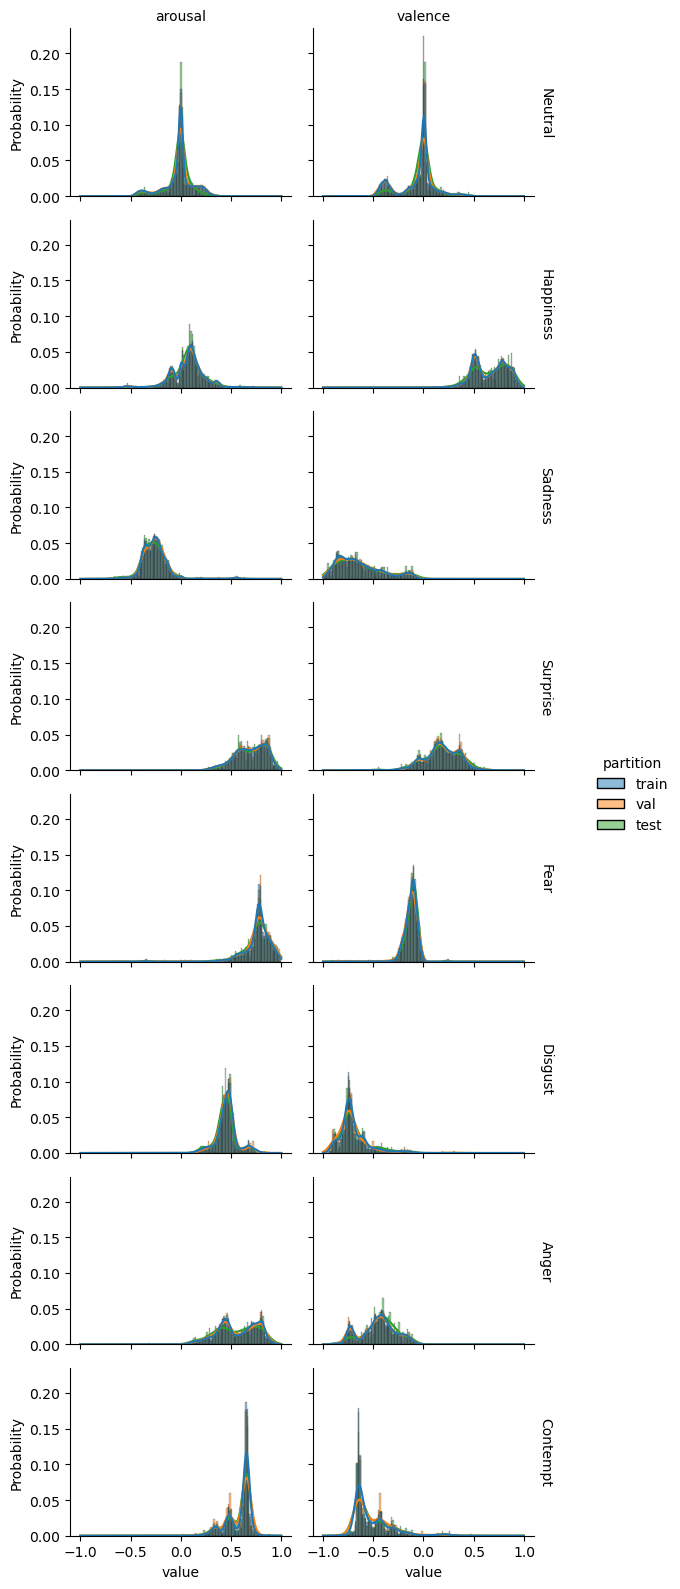

In [11]:
df_histplot_melt = df_fau_full[['arousal', 'valence', 'partition', 'expression', 'img_id']].melt(id_vars=['partition', 'img_id', 'expression'])
label_map = {i: name for i, name in enumerate(dm_fau.expression_labels)}
df_histplot_melt['expression'] = df_histplot_melt['expression'].map(label_map)
g = sns.displot(
    df_histplot_melt, x="value", row='expression', col="variable", hue="partition",
    kind='hist', stat='probability', common_norm=False, kde=True,
    aspect=1.5, height=2, row_order=dm_fau.expression_labels, 
    facet_kws = {'margin_titles': True}
)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}');

### Facial Action Unit Distributions Per Emotion Category

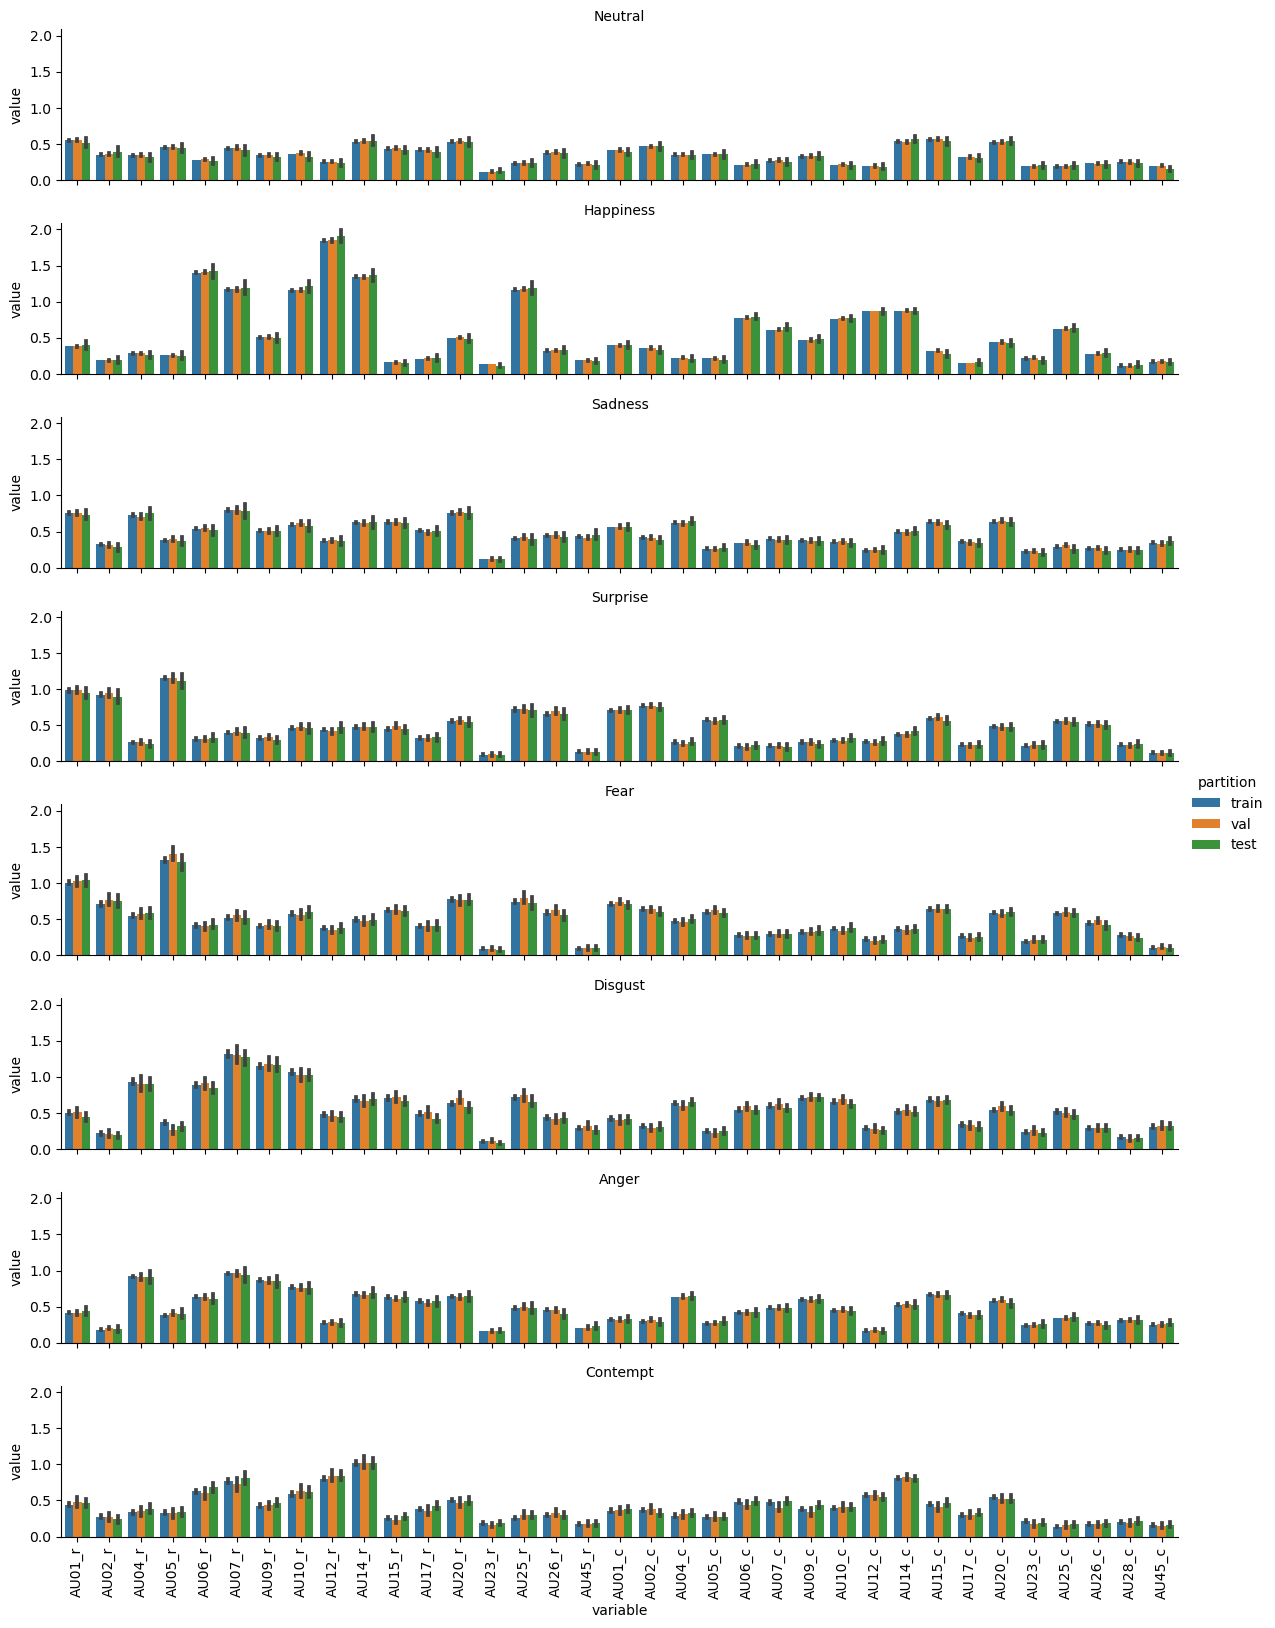

In [13]:
df_catplot_melt = df_fau_full.drop(['arousal', 'valence'], axis=1).melt(id_vars=['partition', 'img_id', 'expression'])
label_map = {i: name for i, name in enumerate(dm_fau.expression_labels)}
df_catplot_melt['expression'] = df_catplot_melt['expression'].map(label_map)
g = sns.catplot(
    data=df_catplot_melt, x='variable', y='value', hue='partition', row='expression', kind='bar', 
    aspect=6, height=2, row_order=dm_fau.expression_labels, 
    facet_kws = {'margin_titles': True}
)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_xticklabels(rotation=90);

## Image Dataset Review

In [14]:
label_type = ['arousal', 'valence', 'expression']
data_root = Path('../data/')
val_split = 0.1
batch_size = 100

In [15]:
dm_img = AffectNetImageDataModule(label_type=label_type, data_root=data_root, val_split=val_split, batch_size=batch_size, refresh_cache=False, keep_as_pandas=True)
dm_img.prepare_data()
dm_img.setup(stage=None)

In [16]:
df_img_train = dm_img.train_dataset.dataset.df.iloc[dm_img.train_dataset.indices]
df_img_train = df_img_train.reset_index()
df_img_train = df_img_train.astype({"expression": int}, errors='raise') 
df_tmp = pd.DataFrame(data=['train']*len(df_img_train), columns=['partition'])
df_img_train = pd.concat([df_img_train, df_tmp], axis=1)

df_img_val = dm_img.val_dataset.dataset.df.iloc[dm_img.val_dataset.indices]
df_img_val = df_img_val.reset_index()
df_img_val = df_img_val.astype({"expression": int}, errors='raise') 
df_tmp = pd.DataFrame(data=['val']*len(df_img_val), columns=['partition'])
df_img_val = pd.concat([df_img_val, df_tmp], axis=1)

df_img_test = dm_img.test_dataset.df
df_img_test = df_img_test.reset_index()
df_img_test = df_img_test.astype({"expression": int}, errors='raise') 
df_tmp = pd.DataFrame(data=['test']*len(df_img_test), columns=['partition'])
df_img_test = pd.concat([df_img_test, df_tmp], axis=1)

df_img_all = pd.concat([df_img_train, df_img_val, df_img_test], axis=0)

In [17]:
df_img_all.sample(10)

index  Unnamed: 0                          filepath  img_id  \
228008   76970           0  data/train_set/images/253751.jpg  253751   
17995    32521           0  data/train_set/images/405779.jpg  405779   
155996   20004           0  data/train_set/images/349024.jpg  349024   
107869  142383           0  data/train_set/images/332885.jpg  332885   
153340  232605           0  data/train_set/images/275602.jpg  275602   
217643   39199           0  data/train_set/images/299396.jpg  299396   
206528   36102           0  data/train_set/images/262347.jpg  262347   
18045   174193           0  data/train_set/images/109661.jpg  109661   
152601  211865           0  data/train_set/images/238676.jpg  238676   
37832    71186           0   data/train_set/images/32555.jpg   32555   

         arousal   valence  expression    lnd_1_x     lnd_1_y    lnd_2_x  ...  \
228008  0.204283  0.366300           1  29.554048  133.741176  33.987543  ...   
17995   0.460601 -0.701531           6  27.335593   88.771879  26.697763  ...   
155996  0.363618  0.787009           1  31.337877   81.425006  30.397630  ...   
107869 -0.555556  0.658730           1  30.724687   78.907544  31.258589  ...   
153340 -0.067751  0.798490           1  -1.535670   92.707682   3.036701  ...   
217643 -0.072150 -0.066138           0  16.692429   76.772500  19.172881  ...   
206528  0.650794  0.277778           3  38.320537   86.296709  36.080537  ...   
18045  -0.033875  0.087108           0  18.483222   97.568545  25.558941  ...   
152601 -0.100084  0.827012           1   7.539031   83.712821  13.913656  ...   
37832  -0.004313  0.008627           0  -8.228221   57.783333 -10.025031  ...   

          lnd_64_y    lnd_65_x    lnd_65_y    lnd_66_x    lnd_66_y  \
228008  161.264498  159.288028  160.163875  135.942422  168.596817   
17995   161.388606  143.086644  163.268848  116.677424  166.099394   
155996  158.720822  128.772346  165.279795  102.141235  172.103312   
107869  168.408304  147.729640  168.482025  120.253103  176.639595   
153340  160.775365  152.150653  156.371605  129.742955  169.699060   
217643  168.256667  151.313898  161.670833  129.230282  165.608333   
206528  158.501266  126.672752  165.093671  105.595705  171.629367   
18045   160.041296  150.708953  158.578715  136.891323  174.184909   
152601  166.123761  158.033480  158.590085  135.544670  166.717265   
37832   182.920000  128.930552  182.256667  116.280736  185.203333   

          lnd_67_x    lnd_67_y    lnd_68_x    lnd_68_y  partition  
228008  125.812042  173.076817  115.526644  176.417439      train  
17995   104.308068  167.796364   93.601627  166.343758      train  
155996   92.271407  171.459204   84.099556  169.029422      train  
107869  108.868176  176.514835   98.864234  174.220962      train  
153340  118.843162  171.521556  107.612371  172.029822      train  
217643  117.815141  166.979167  107.608588  165.940833      train  
206528   98.274362  171.898734   92.200805  170.169114      train  
18045   126.959540  178.038792  117.089620  178.604635      train  
152601  124.680176  170.019829  114.447225  170.153846      train  
37832   107.509693  186.236667   98.807362  184.063333      train  

[10 rows x 144 columns]

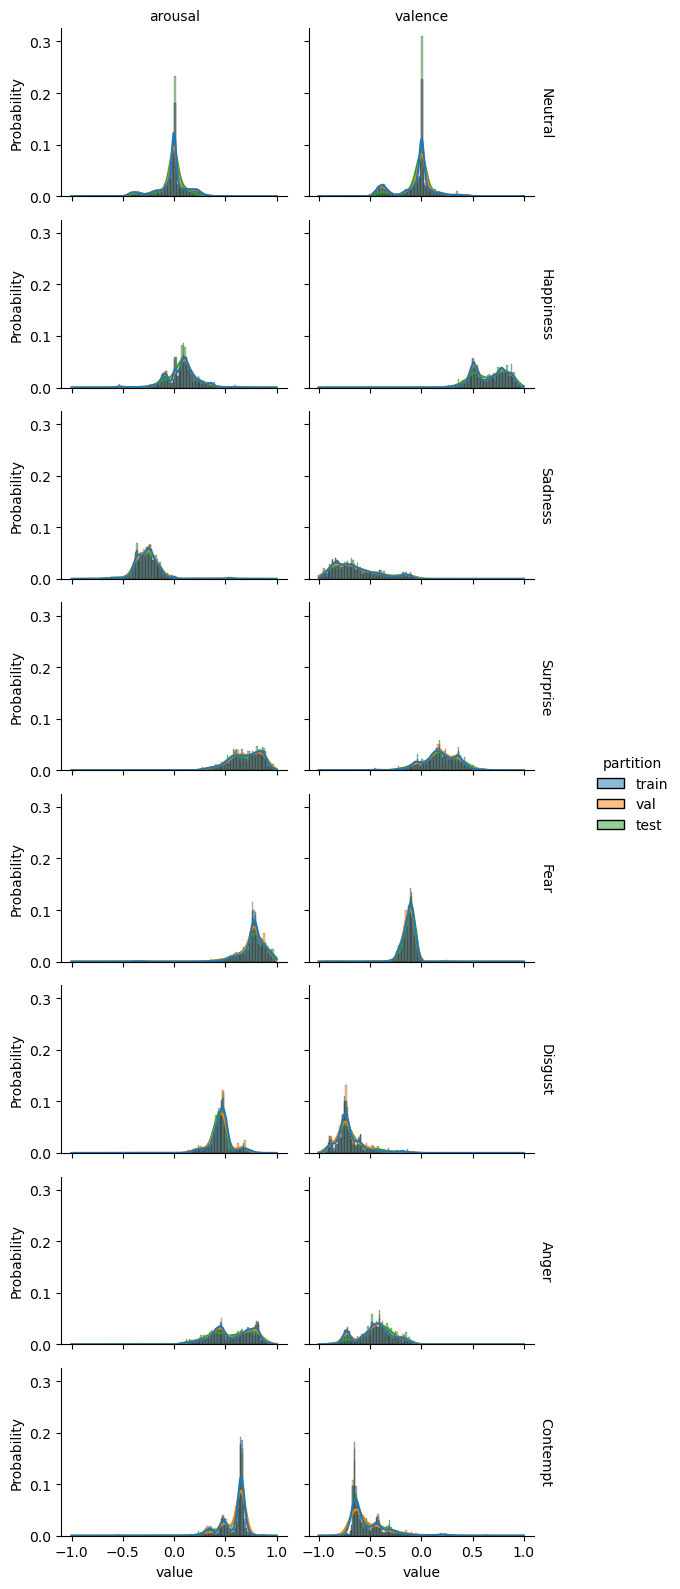

In [18]:
df_histplot_melt = df_img_all[['arousal', 'valence', 'partition', 'expression', 'img_id']].melt(id_vars=['partition', 'img_id', 'expression'])
label_map = {i: name for i, name in enumerate(dm_img.expression_labels)}
df_histplot_melt['expression'] = df_histplot_melt['expression'].map(label_map)
g = sns.displot(
    df_histplot_melt, x="value", row='expression', col="variable", hue="partition",
    kind='hist', stat='probability', common_norm=False, kde=True,
    aspect=1.5, height=2, row_order=dm_img.expression_labels, 
    facet_kws = {'margin_titles': True}
)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}');

In [19]:
def plt_imgs(df, expression_labels, n_exp_imgs=5, random_state=30):
    plt.figure(figsize=(8, 12))
    for i, exp in enumerate(expression_labels, start=0):  
        img_files = df[df.expression == i]['filepath'].sample(5, random_state=random_state)
        for j, f in enumerate(img_files, start=1):
            with open(Path('..') / f, "rb") as f:
                img = Image.open(f)
                img = img.convert("RGB")
            plt.subplot(len(dm_img.expression_labels), n_exp_imgs, i*n_exp_imgs + j)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            if j == 1:
                plt.ylabel(f'{exp}')
    plt.tight_layout();

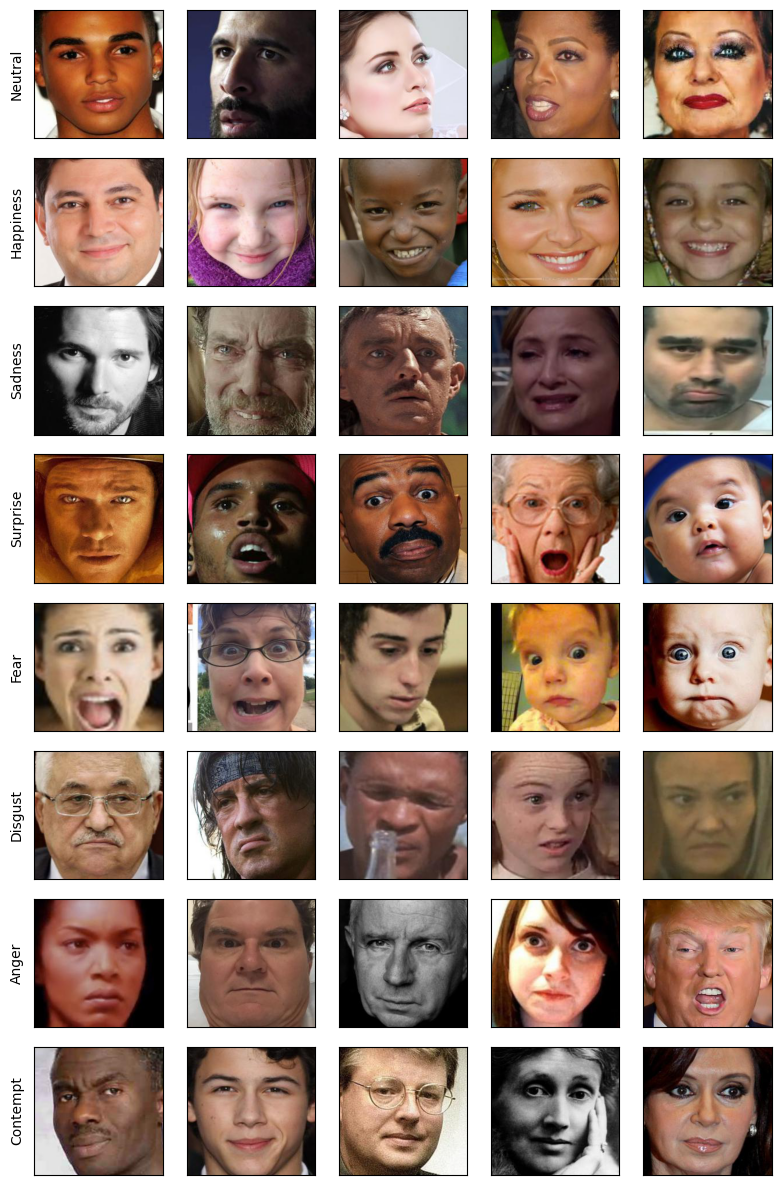

In [20]:
# View Train Images
plt_imgs(df_img_train, dm_img.expression_labels)

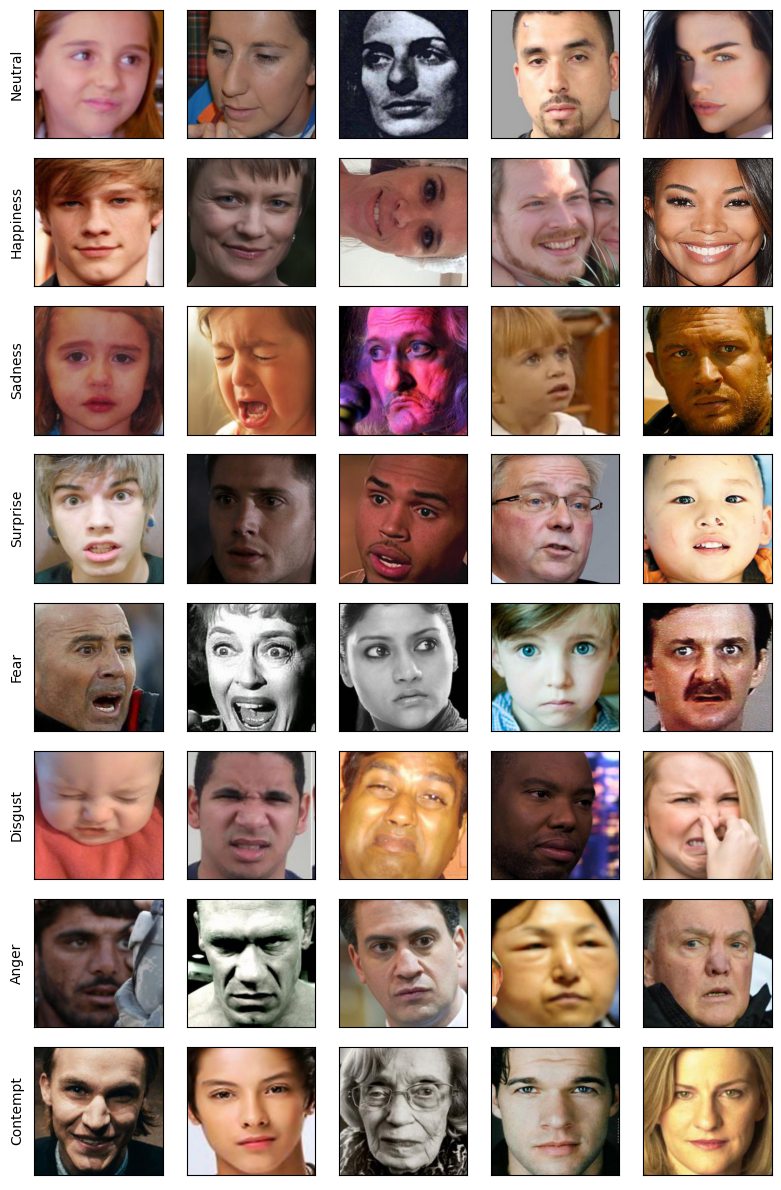

In [21]:
# plot validation images
plt_imgs(df_img_val, dm_img.expression_labels)

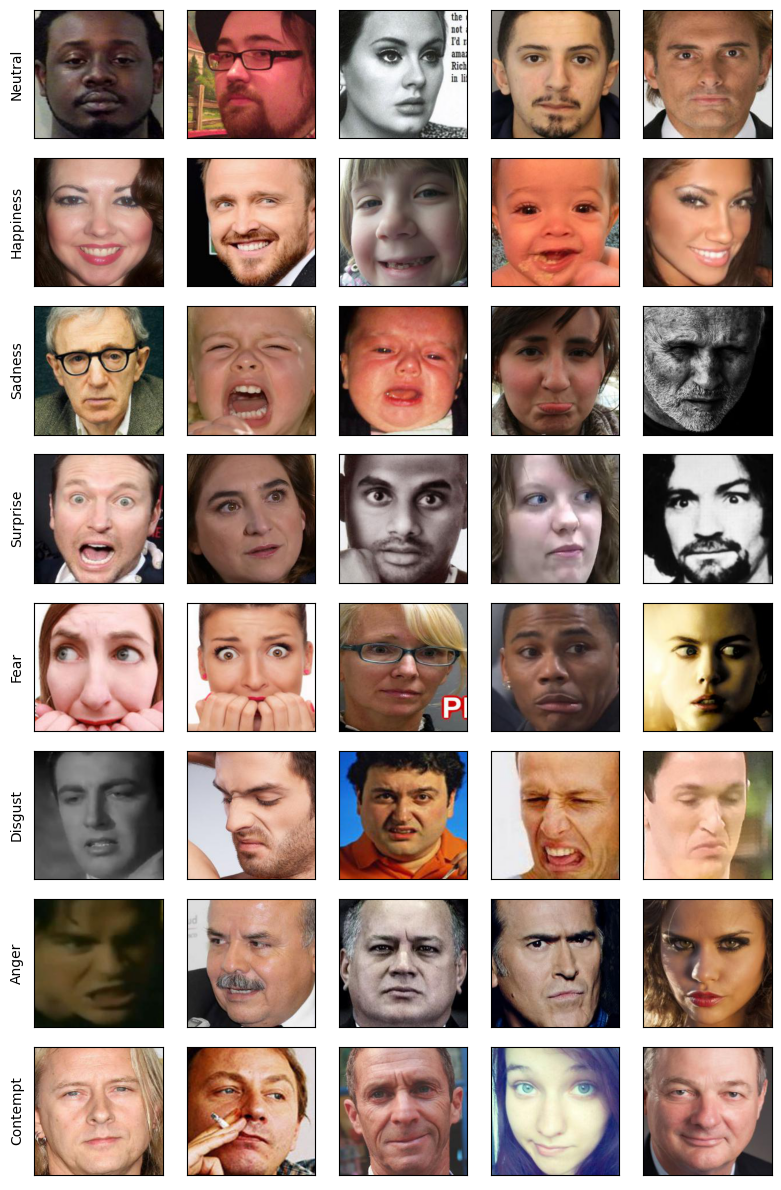

In [22]:
#plot test images
plt_imgs(df_img_test, dm_img.expression_labels)